# PN expert

In [17]:
import numpy as np
import pandas as pd
import os
from plotly import graph_objects as go

from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas()

from collections import defaultdict
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import plotly.express as px
import warnings
from pytorch_tabnet.tab_model import TabNetClassifier


In [18]:
DATA_FOLDER = 'ds'
BASE_RAW_DATA_PATH = '../data'

TRAIN_CSV_PATH = os.path.join(DATA_FOLDER, 'train.csv')
TEST_CSV_PATH = os.path.join(DATA_FOLDER, 'test.csv')
TEST_CSV_WITH_RESULTS_PATH = os.path.join(DATA_FOLDER, 'platform.csv')
TARGET_LABEL = 'folder_path'

RANDOM_STATE = 7575

In [19]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_WITH_RESULTS_PATH)

In [20]:
train_df

,имя файла данных,Folder Path,пол,полных лет,пациент off/on,определенный диагноз врачом (0-5)
0,raw_data_d786d645-db38-11ec-b494-e82aea2c97f4.csv,кинетический тремор,мужской,52,off,1
1,raw_data_bdcba44f-0d6a-11ed-8857-b6da2cf29e9d.csv,Постуральный тремор,мужской,78,on,0
2,raw_data_750c0f09-b09a-11ec-9699-58a023d3f6d9.csv,Постуральный тремор,мужской,71,on,0
3,raw_data_d90846c3-3969-11ed-a96d-b469216ca443.csv,кулак,мужской,23,off,1
4,raw_data_c27fbeb3-1882-11ed-95c1-b469216ca443.csv,кинетический тремор,мужской,23,off,2
...,...,...,...,...,...,...
828,raw_data_e454ecdf-6fd9-11ed-8c3e-e82aea2c97f4.csv,Постуральный тремор,мужской,63,on,0
829,raw_data_ed2a29d7-c16e-11ec-b4b8-e82aea2c97f4.csv,Постуральный тремор,женский,66,on,3
830,raw_data_f4a07d6b-64c3-11ed-aa07-e82aea2c97f4.csv,Постуральный тремор,женский,67,off,0
831,raw_data_c00aef37-0d5e-11ed-898c-80847c24eb6e.csv,кинетический тремор,мужской,61,on,0


In [21]:
train_df.columns = ['filename', 'folder_path', 'gender', 'age', 'neiro_stim', 'diagnos']
test_df.columns = ['filename', 'folder_path', 'gender', 'age', 'neiro_stim', 'diagnos', 'private']

In [22]:
train_df

,filename,folder_path,gender,age,neiro_stim,diagnos
0,raw_data_d786d645-db38-11ec-b494-e82aea2c97f4.csv,кинетический тремор,мужской,52,off,1
1,raw_data_bdcba44f-0d6a-11ed-8857-b6da2cf29e9d.csv,Постуральный тремор,мужской,78,on,0
2,raw_data_750c0f09-b09a-11ec-9699-58a023d3f6d9.csv,Постуральный тремор,мужской,71,on,0
3,raw_data_d90846c3-3969-11ed-a96d-b469216ca443.csv,кулак,мужской,23,off,1
4,raw_data_c27fbeb3-1882-11ed-95c1-b469216ca443.csv,кинетический тремор,мужской,23,off,2
...,...,...,...,...,...,...
828,raw_data_e454ecdf-6fd9-11ed-8c3e-e82aea2c97f4.csv,Постуральный тремор,мужской,63,on,0
829,raw_data_ed2a29d7-c16e-11ec-b4b8-e82aea2c97f4.csv,Постуральный тремор,женский,66,on,3
830,raw_data_f4a07d6b-64c3-11ed-aa07-e82aea2c97f4.csv,Постуральный тремор,женский,67,off,0
831,raw_data_c00aef37-0d5e-11ed-898c-80847c24eb6e.csv,кинетический тремор,мужской,61,on,0


Перед нами стоит задачи многоклассовой классификации (колонка целевой переменной: folder_path). Посмотрим сколько классов и что это за классы

In [1291]:
classes = train_df[TARGET_LABEL].unique()
classes

array(['кинетический тремор', 'Постуральный тремор', 'кулак',
       'постукивание пальцами', 'Пронация и супинация кисти'],
      dtype=object)

## КИНЕТИЧЕСКИЙ ТРЕМОР РУК

**Кратко: руки вперед, поочередное касание своего носа и пальца доктора**

Инструкции для исследующего: В данному пункте оценивается тремор, выявляемый с помощью пальценосовой пробы. Вначале пациента просят вытянуть руку вперед, а затем поочередно дотрагиваться до своего носа и до пальца исследующего. Проба выполняется каждой рукой не менее трех раз. Пальценосовая проба должна выполняться достаточно медленно, чтобы не пропустить дрожание, которое может становиться незаметным при очень быстром движении руки. Затем проба повторяется другой рукой. Каждая рука оценивается отдельно. Тремор может отмечаться во время всего движения или появляться лишь при достижении одной из целей (носа или пальца). При оценке принимается во внимание максимальная наблюдаемая амплитуда дрожания.


## ПОСТУРАЛЬНЫЙ ТРЕМОР РУК

**Кратко: прямые руки вперед, ладони вниз, пальцы разведены и не касаются друг друга. Наблюдают 10 секунд**

Инструкции для исследующего: В данном пункте необходимо учитывать любой тремор, отмечающийся в указанной позе, включая тремор покоя, возобновляющийся при удержании позы Каждая рука оценивается отдельно. При оценке принимается во внимание максимальная наблюдаемая амплитуда дрожания. Попросите пациента вытянуть прямые руки перед собой ладонями вниз. Кисти должны быть выпрямлены, а пальцы удобно для пациента разведены, так чтобы они не касались друг друга. Понаблюдайте за этой позой 10 секунд.

## ПОСТУКИВАНИЕ ПАЛЬЦАМИ

**Кратко: стук большого пальца по указательному, быстро и с максимально возможной амплитудой**

Инструкции для исследующего: Каждая рука проверяется отдельно. Продемонстрируйте задание, но не продолжайте показ в то время, когда пациент будет его выполнять. Попросите пациента постучать указательным пальцем по большому 10 раз как можно быстрее и с максимально возможной амплитудой. Каждая сторона оценивается отдельно, при этом учитываются скорость, амплитуда, задержки и остановки движений, уменьшение их амплитуды во времени.

## ПРОНАЦИЯ-СУПИНАЦИЯ КИСТЕЙ

**Кратко: рука вперед, ладонь вниз, затем поворачиваем попеременно ладонь вверх и вниз 10 раз**

Инструкции для исследующего: Каждая рука проверяется отдельно. Продемонстрируйте задание, но не продолжайте показ в то время, когда пациент будет его выполнять. Попросите пациента вытянуть руку перед собой ладонью вниз, затем поворачивать ладонь попеременно вверх и вниз 10 раз с максимально возможной скоростью и амплитудой. Исследуйте каждую сторону отдельно, обращая внимание на скорость, амплитуду, задержки и остановки движений, постепенное снижение их амплитуды

## КИСТЕВЫЕ ДВИЖЕНИЯ (КУЛАК)

**Кратко: рука согнута в локте, чтобы ладонь была направлена на доктора. Нужно сжать кулак и разжать кисть 10 раз как можно более полно и быстро.** 

Инструкции для исследующего: Каждая рука проверяется отдельно. Продемонстрируйте задание, но не продолжайте показ в то время, когда пациент будет его выполнять. Попросите пациента крепко сжать кисть в кулак, при этом предплечье должно быть согнуто в локте таким образом, чтобы ладонь пациента была обращена к исследующему. Пациент должен разжать кисть 10 раз как можно более полно и как можно быстрее. Если пациент не сжимает кисть в кулак крепко и не разжимает ее полностью, ему следует напоминать об этом. Каждая сторона оценивается отдельно, при этом учитываются скорость, амплитуда, задержки и остановки движений, уменьшение их амплитуды во времени.

In [23]:
# get finger names
ex_df = pd.read_csv(os.path.join(BASE_RAW_DATA_PATH, 'raw_data_fcb32e89-2205-11ed-96ab-b469216ca443.csv'))
pref_col_name = np.unique([col_name.split('.')[0] for col_name in ex_df.columns[:-1]])

FileNotFoundError: [Errno 2] No such file or directory: '../data\\raw_data_fcb32e89-2205-11ed-96ab-b469216ca443.csv'

Сравним распределения длин историй в трейне и в тесте

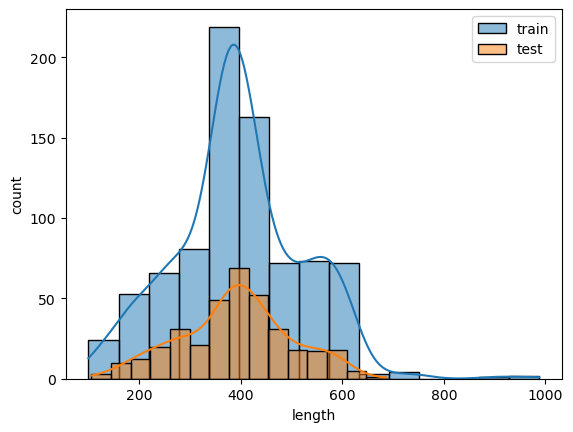

In [1293]:
def draw_length_distribution(train_df, test_df):
    def get_story_len(filename):
        cur_df = pd.read_csv(os.path.join(BASE_RAW_DATA_PATH, filename))
        return cur_df.shape[0]
    _, ax = plt.subplots()

    story_train_lengths = train_df['filename'].apply(get_story_len).values
    story_test_lengths = test_df['filename'].apply(get_story_len).values
    sns.histplot(story_train_lengths, kde=True, bins=15, ax=ax, label='train')
    sns.histplot(story_test_lengths, kde=True, bins=15, ax=ax, label='test')

    ax.set(xlabel='length', ylabel='count')
    plt.legend()

draw_length_distribution(train_df, test_df)

Распределение длин историй для тренировки и для теста достаточно похожи. 

Более того, если ваши признаки (алгоритмы) завязаны на длину истории, то выбросы (объекты с большой длиной истории) из тренировки можно выкинуть.

## Draw exercises examples

In [1294]:
colors_hand_dict = {
        'INDEX_FINGER': 'red',
        'MIDDLE_FINGER': 'blue',
        'PINKY': 'green',
        'RING_FINGER': 'pink',
        'THUMB': 'black',
        'WRIST': 'yellow'
    }
hand_part_names = list(colors_hand_dict.keys())

In [1295]:
def get_hand_points_sequence(filename):
    ex_df = pd.read_csv(os.path.join(BASE_RAW_DATA_PATH, filename))
    seq_hands_points = []
    for _, row in ex_df.iterrows():
        hand_description = {}
        for axis_name in ['x', 'y', 'z']:
            wrist_coor = row[f'{pref_col_name[-1]}.{axis_name}'] # base of hand
            coors_list = [row[f'{col_name}.{axis_name}'] - wrist_coor for col_name in pref_col_name[:-1]] + [0]

            hand_description[axis_name] = coors_list
        seq_hands_points.append(hand_description)
    
    return seq_hands_points

In [1296]:
def plt_create_3d_gif(filename, ex_name):
    seq_hands_points = get_hand_points_sequence(filename)
    hand_part_names_list = [col_name[:col_name.rfind('_')] for col_name in pref_col_name[:-1]] + [pref_col_name[-1]]
    colors_list = [colors_hand_dict[hand_part_name] for hand_part_name in hand_part_names_list]
    frames_list = [go.Frame(data=[go.Scatter3d(x=hand['x'], y=hand['y'], z=hand['z'], mode='markers', 
                                    marker=dict(color=colors_list))])
                for hand in seq_hands_points]

    start_point = seq_hands_points[0]
    start_fig_data = [go.Scatter3d(x=start_point['x'], y=start_point['y'], z=start_point['z'], text=pref_col_name,
                                    mode='markers', 
                                    marker=dict(color=colors_list))]
    fig = go.Figure(
        data=start_fig_data,
        frames=frames_list,
        layout=go.Layout(
            updatemenus=[dict(
                type="buttons",
                buttons=[{
                    "args": [None, {"frame": {"duration": 200, "redraw": True},
                                    "fromcurrent": True, 
                                    "transition": {"duration": 800,
                                                    "easing": "quadratic-in-out"}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }]
        )]),
    )

    x_values = sum([hand['x'] for hand in seq_hands_points], [])
    y_values = sum([hand['y'] for hand in seq_hands_points], [])
    z_values = sum([hand['z'] for hand in seq_hands_points], [])
    fig.update_layout(
        height=400, 
        width=800,
        title=f'Упражнение "{ex_name}"' if ex_name else '',
        scene=dict(
            aspectmode='cube',
            xaxis = dict(range=[min(x_values) - 0.01, max(x_values) + 0.01], nticks=5), 
            yaxis = dict(range=[min(y_values) - 0.01, max(y_values) + 0.01], nticks=5), 
            zaxis = dict(range=[min(z_values) - 0.01, max(z_values) + 0.01], nticks=5), 
        ),
    )
    fig.show()

In [1297]:
train_df_by_class = lambda class_name: train_df[train_df['folder_path'] == class_name]
class_name2obj_with_min_diagnos = {class_name: train_df_by_class(class_name)['diagnos'].argmin()
                                   for class_name in classes}

class2csv_examples = {class_name: train_df_by_class(class_name).iloc[obj_id]['filename']
                      for class_name, obj_id in class_name2obj_with_min_diagnos.items()}

In [1]:
plt_create_3d_gif(class2csv_examples['кинетический тремор'], ex_name='кинетический тремор')

NameError: name 'plt_create_3d_gif' is not defined

In [2]:
plt_create_3d_gif(class2csv_examples['Постуральный тремор'], ex_name='Постуральный тремор')

NameError: name 'plt_create_3d_gif' is not defined

In [2]:
plt_create_3d_gif(class2csv_examples['кулак'], ex_name='кулак')

NameError: name 'plt_create_3d_gif' is not defined

In [1301]:
plt_create_3d_gif(class2csv_examples['постукивание пальцами'], ex_name='постукивание пальцами')

In [1302]:
plt_create_3d_gif(class2csv_examples['Пронация и супинация кисти'], ex_name='Пронация и супинация кисти')

## Feature generation

In [1303]:
fing_columns_sequence = {
    fing_name: [f'{fing_name}_MCP', f'{fing_name}_PIP', f'{fing_name}_DIP', f'{fing_name}_TIP']
    for fing_name in hand_part_names if fing_name not in ['THUMB', 'WRIST'] # без большого пальца и точки основания ладони
}

In [1304]:
def get_angle_between_vectors(vect_1, vect_2):
    cos_of_beta = np.dot(vect_1, vect_2) / np.sqrt((vect_1**2).sum() * (vect_2**2).sum())

    return np.pi - np.arccos(cos_of_beta)

def get_angle_between_plane_and_line(plane_point_1, plane_point_2, plane_point_3, line_point_1, line_point_2):
    plane_vect_1 = plane_point_2 - plane_point_3
    plane_vect_2 = plane_point_2 - plane_point_1
    norm_vect = np.cross(plane_vect_1, plane_vect_2)

    line_vect = line_point_2 - line_point_1

    cos_of_alpha = abs(np.dot(norm_vect, line_vect)) / np.sqrt((norm_vect**2).sum() * (line_vect**2).sum()) # abs for angle between 0 and pi/2
    alpha = np.pi / 2 - np.arccos(cos_of_alpha)

    return alpha

In [1305]:
def get_point_by_point_name(row, fing_name):
    return row[[f'{fing_name}.x', f'{fing_name}.y', f'{fing_name}.z']].values

In [1306]:
def generate_features_from_series(filename):
    ex_df = pd.read_csv(os.path.join(BASE_RAW_DATA_PATH, filename))
    new_features_dict = defaultdict(list)
    for _, row in ex_df.iterrows():
        plane_point_1 = get_point_by_point_name(row, 'WRIST')
        plane_point_2 = get_point_by_point_name(row, 'INDEX_FINGER_MCP')
        plane_point_3 = get_point_by_point_name(row, 'PINKY_MCP')
        new_features_dict['TIME'].append(row['TIME'])

        for fing_name, node_name in fing_columns_sequence.items():
            fing_node_1 = get_point_by_point_name(row, f'{fing_name}_MCP')
            fing_node_2 = get_point_by_point_name(row, f'{fing_name}_PIP')
            fing_node_3 = get_point_by_point_name(row, f'{fing_name}_DIP')
            fing_node_4 = get_point_by_point_name(row, f'{fing_name}_TIP')

            new_features_dict[f'{fing_name}_angle_1'].append(
                get_angle_between_plane_and_line(
                    plane_point_1, 
                    plane_point_2, 
                    plane_point_3, 
                    fing_node_1, 
                    fing_node_2
                ))
            new_features_dict[f'{fing_name}_angle_2'].append(
                get_angle_between_vectors(
                    fing_node_3 - fing_node_2,
                    fing_node_2 - fing_node_1
                ))
            new_features_dict[f'{fing_name}_angle_3'].append(
                get_angle_between_vectors(
                    fing_node_4 - fing_node_3,
                    fing_node_3 - fing_node_2
                ))
        fings_list = list(fing_columns_sequence.keys())
        for i, fing_name_1 in enumerate(['THUMB'] + fings_list):
            for j, fing_name_2 in enumerate(['THUMB'] + fings_list):
                if j > i:
                    fing_1_end_node = get_point_by_point_name(row, f'{fing_name_1}_TIP')
                    fing_2_end_node = get_point_by_point_name(row, f'{fing_name_2}_TIP')
                    new_features_dict[f'distance_between_{fing_name_1}_and_{fing_name_2}_ends'].append(
                        np.sqrt(((fing_1_end_node - fing_2_end_node)**2).sum())
                    )

    res_df = pd.DataFrame(new_features_dict).drop(columns='TIME')
    res_df = res_df.agg(['max', 'min', 'mean', 'std']).unstack()

    res_df.index = ["_".join(i) for i in res_df.index]
    res_df = res_df.to_frame().T
    return res_df.iloc[0]
    

In [1307]:
def create_df_with_features(df, csv_path_to_save: str = None):
    if csv_path_to_save and os.path.exists(csv_path_to_save):
        return pd.read_csv(csv_path_to_save)
    new_feats_df = df.progress_apply(lambda x: generate_features_from_series(x['filename']), axis=1)
    new_feats_df = pd.concat([new_feats_df, df], axis=1).drop(columns='filename')
    if csv_path_to_save:
        new_feats_df.to_csv(csv_path_to_save, index=False)
    
    return new_feats_df

In [1308]:
train_feat_df = create_df_with_features(train_df, 'train_df_features.csv')
train_feat_df[TARGET_LABEL] = train_feat_df[TARGET_LABEL].apply(lambda class_name: np.where(classes == class_name)[0][0])

In [1309]:
test_feat_df = create_df_with_features(test_df, 'test_df_features.csv')
test_feat_df[TARGET_LABEL] = test_feat_df[TARGET_LABEL].apply(lambda class_name: np.where(classes == class_name)[0][0])

Посмотрим на обычную корреляюцию признаков и подумаем, что делать с сильно скоррелированными признаками

In [1310]:
def delete_corr_features(df, threshold):
    """
    Function delete corr features (some remain to delete corr)
    """
    print('Shape before delete corr:', df.shape)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()
    columns_to_drop = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in df.columns:
                    columns_to_drop.append(colname)
                    del df[colname] # deleting the column from the dataset

    print('Shape after:', df.shape)
    return df, columns_to_drop

train_feat_df, columns_to_drop = delete_corr_features(train_feat_df, 0.9)
test_feat_df = test_feat_df.drop(columns=columns_to_drop)

Shape before delete corr: (833, 93)
Shape after: (833, 60)


/var/folders/3g/cf8x3_sj1jl0nsrsxc6zyt1h0000gn/T/ipykernel_24772/1354176245.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Позже мы ещё посмотрим на важность фичей и какие-то из этих фичей ещё выкинем

## Train models

In [1311]:
filtered_features = train_feat_df.columns
cat_features = ['gender', 'neiro_stim', 'diagnos']

In [1312]:
# try delete gender, neiro_stim, diagnos features
#filtered_features = list(filter(lambda x: x not in ['gender', 'neiro_stim'], train_feat_df.columns))
#cat_features = ['diagnos']

In [1313]:
CATBOOST_CONFIG = {
    'depth': 6,
    'iterations': 3500,
    'learning_rate': 0.06,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'colsample_bylevel': 0.098,
    'subsample': 0.95,
    'l2_leaf_reg': 9,
    'min_data_in_leaf': 40,
    'max_bin': 187,
    'random_strength': 1,
    'task_type': "CPU",    
    'thread_count': -1,
    'bootstrap_type': "Bernoulli", 
    'random_seed': RANDOM_STATE,
    'auto_class_weights': "SqrtBalanced",
    'early_stopping_rounds': 50
}

In [1314]:
XGB_CONFIG = {
    'params': {
        'n_estimators': 3500,
        'objective': 'multi:softprob',
        'tree_method': 'hist',
        'num_class': classes.shape[0],
        'seed': RANDOM_STATE,
        'early_stopping_rounds': 50,
        'eval_metric': 'merror',
        'eta': 0.001,
        'max_depth': 6, 
        'learning_rate': 0.06,
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001, 
    },
    'verbose': 5
}

In [1315]:
def fit_xgb_clf(X_train, y_train, X_val, y_val):
    dtrain = xgb.DMatrix(X_train,
                        label=y_train,
                        nthread=-1,
                        enable_categorical=True)

    dval = xgb.DMatrix(X_val,
                        y_val,
                        nthread=-1,
                        enable_categorical=True)

    model = XGBClassifier(**XGB_CONFIG['params'], enable_categorical=True)
    fit_config = XGB_CONFIG.copy()
    del fit_config['params']

    model.fit(X_train, y_train, **fit_config, eval_set=[(X_val, y_val)])


    return model, dtrain, dval

In [1316]:
def fit_catboost_clf(X_train, y_train, X_val, y_val, cat_features):
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_val, label=y_val, cat_features=cat_features)

    clf = CatBoostClassifier(**CATBOOST_CONFIG, cat_features=cat_features)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    return clf

#### Обертка для TabNet

Сделаем обертку для TabNetClassifier
По-умолчанию он не умеет работать с pd.DataFrame, а принимает на вход np.array. В то же время бустинги, которые мы хотим использовать принимают pd.DataFrame. Чтобы потом можно было это соединить в единый ансамбль, напишем обёртку, которая научит TabNetClassifier работать с датафреймами

In [1317]:
class TabNetClassifierDataFrameInput(TabNetClassifier):
    def fit(self, X, y, **kwargs):
        if 'eval_set' in kwargs:
            kwargs['eval_set'] = [(ev_set[0].values, ev_set[1].values) for ev_set in kwargs['eval_set']]
        return super().fit(X.values, y.values, **kwargs)
    
    def predict(self, X, **kwargs):
        return super().predict(X.values, **kwargs)
    
    def predict_proba(self, X, **kwargs):
        return super().predict_proba(X.values, **kwargs)

Напишем функцию для стратифицированной кросс валидации

In [1318]:
def model_stratified_cross_val(model_name='catboost', folder_path_to_models='../models', df=train_feat_df, filtered_features=filtered_features, cat_features=cat_features, n_splits=3):
    clfs = []
    scores = []

    X = df[filtered_features].drop(TARGET_LABEL, axis=1, errors="ignore")
    y = df[TARGET_LABEL]

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if model_name == 'catboost':
            clf = fit_catboost_clf(X_train, y_train, X_val, y_val, cat_features)
            scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "Accuracy" in k], dtype="float16"))

            clf.save_model(os.path.join(folder_path_to_models, f"catboost_model_{i}"))
        elif model_name == 'xgb':
            clf, _, _ = fit_xgb_clf(X_train, y_train, X_val, y_val)
            preds = clf.predict(X_val)

            scores.append(accuracy_score(preds, y_val))
        elif model_name == 'tabnet':
            clf = TabNetClassifierDataFrameInput(verbose=10, seed=RANDOM_STATE)
            weights = y_train.shape[0] / y_train.value_counts()
            clf.fit(
                X_train,
                y_train,
                eval_set=[
                    (X_val, y_val)
                ],
                eval_name=[
                    'val'
                ],
                patience=5,
                max_epochs=100, 
                batch_size=8,
                weights=y_train.apply(lambda x: weights[x]),
                eval_metric=['accuracy'])
            train_preds = clf.predict(X_train)
            print('TabNet train acc:', accuracy_score(train_preds, y_train))
            preds = clf.predict(X_val)

            scores.append(accuracy_score(preds, y_val))
        else:
            raise ValueError(f'model_name={model_name} is not known')
        clfs.append(clf)

        os.makedirs(folder_path_to_models, exist_ok=True)

    assert len(clfs) == n_splits
    print("mean Accuracy score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"), f'std score={np.std(scores, dtype="float16")}')

    return clfs, X, y


catboost_clfs, catboost_X, catboost_y = model_stratified_cross_val(
    model_name='catboost',
    df=train_feat_df, 
    filtered_features=filtered_features, 
    cat_features=cat_features, 
    n_splits=3
)

0:	learn: 0.6276481	test: 0.5652213	best: 0.5652213 (0)	total: 1.45ms	remaining: 5.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9103724692
bestIteration = 56

Shrink model to first 57 iterations.
0:	learn: 0.6252591	test: 0.6389449	best: 0.6389449 (0)	total: 1.22ms	remaining: 4.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9408736908
bestIteration = 178

Shrink model to first 179 iterations.
0:	learn: 0.7312153	test: 0.6782288	best: 0.6782288 (0)	total: 3.63ms	remaining: 12.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9028868666
bestIteration = 55

Shrink model to first 56 iterations.
mean Accuracy score ---------> 0.9014 std score=0.0164947509765625


Всего признаков 59 Усреднее по 3-ти моделям: 
На график нанесено топ-40 признаков


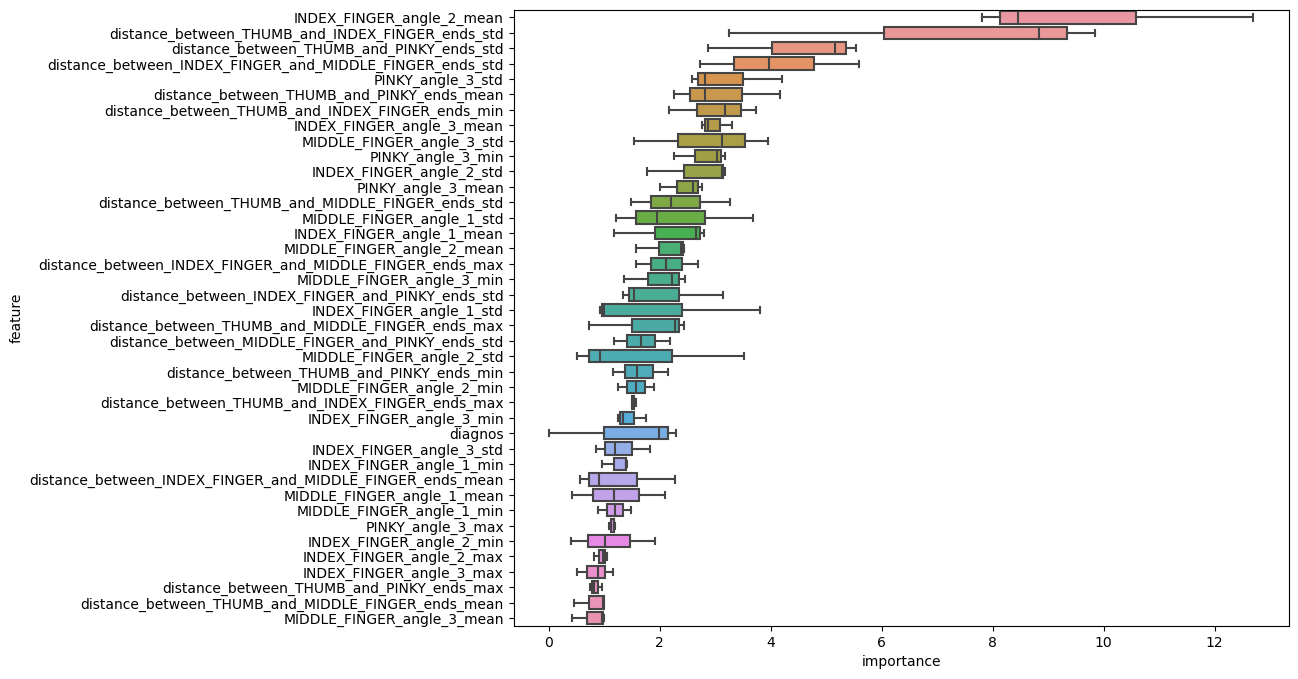

In [1319]:
def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    catboost_X,
    best_model = catboost_clfs,
    height = 0.20,
    top_n=40,
)

Выберем 40 лучших фичей по feature_importance

In [1320]:
new_df = train_feat_df[df_feats_imp['feature'].values[:40].tolist() + [TARGET_LABEL]]
filtered_features = list(set(filtered_features) & set(new_df.columns)) + [TARGET_LABEL]
cat_features = list(set(cat_features) & set(new_df.columns))

In [1321]:
def transform_df_to_xgboost(df):
    new_df = df.copy()
    new_df['gender'] = new_df['gender'].astype('category')
    new_df['neiro_stim'] = new_df['neiro_stim'].astype('category')
    new_df['folder_path'] = new_df['folder_path'].astype('category')

    return new_df

Посмотрим на катбуст, xgboost и tabnet на этих фичах

In [1322]:
catboost_clfs, catboost_X, catboost_y = model_stratified_cross_val(
    model_name='catboost',
    df=new_df, 
    filtered_features=filtered_features, 
    cat_features=cat_features, 
    n_splits=3
)

0:	learn: 0.6117857	test: 0.5684221	best: 0.5684221 (0)	total: 1.84ms	remaining: 6.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9194765853
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 0.6283792	test: 0.5963739	best: 0.5963739 (0)	total: 1.27ms	remaining: 4.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9249731145
bestIteration = 113

Shrink model to first 114 iterations.
0:	learn: 0.7103626	test: 0.6411467	best: 0.6411467 (0)	total: 2.4ms	remaining: 8.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9240890299
bestIteration = 227

Shrink model to first 228 iterations.
mean Accuracy score ---------> 0.921 std score=0.0024776458740234375


In [1323]:
xgb_clfs, xgb_X, xgb_y = model_stratified_cross_val(
    model_name='xgb',
    df=transform_df_to_xgboost(train_feat_df), 
    filtered_features=filtered_features, 
    cat_features=cat_features, 
    n_splits=3
)

[0]	validation_0-merror:0.21583
[5]	validation_0-merror:0.09712
[10]	validation_0-merror:0.09712
[15]	validation_0-merror:0.09712
[20]	validation_0-merror:0.09353
[25]	validation_0-merror:0.09353
[30]	validation_0-merror:0.08993
[35]	validation_0-merror:0.08633
[40]	validation_0-merror:0.08633
[45]	validation_0-merror:0.08633
[50]	validation_0-merror:0.08273
[55]	validation_0-merror:0.08633
[60]	validation_0-merror:0.08273
[65]	validation_0-merror:0.08273
[70]	validation_0-merror:0.08273
[75]	validation_0-merror:0.08273
[80]	validation_0-merror:0.08273
[85]	validation_0-merror:0.07914
[90]	validation_0-merror:0.08273
[95]	validation_0-merror:0.07554
[100]	validation_0-merror:0.07554
[105]	validation_0-merror:0.07914
[110]	validation_0-merror:0.07914
[115]	validation_0-merror:0.07914
[120]	validation_0-merror:0.08273
[121]	validation_0-merror:0.08273
[0]	validation_0-merror:0.20863
[5]	validation_0-merror:0.07914
[10]	validation_0-merror:0.07194
[15]	validation_0-merror:0.05755
[20]	val

In [1324]:
tabnet_clfs, tabnet_X, tabnet_y = model_stratified_cross_val(
    model_name='tabnet',
    df=train_feat_df, 
    filtered_features=filtered_features, 
    cat_features=cat_features, 
    n_splits=3
)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.59662 | val_accuracy: 0.2482  |  0:00:00s
epoch 10 | loss: 1.01417 | val_accuracy: 0.57554 |  0:00:08s
epoch 20 | loss: 0.73492 | val_accuracy: 0.78777 |  0:00:16s
epoch 30 | loss: 0.63789 | val_accuracy: 0.85971 |  0:00:23s
epoch 40 | loss: 0.51129 | val_accuracy: 0.92086 |  0:00:31s

Early stopping occurred at epoch 49 with best_epoch = 44 and best_val_accuracy = 0.92806


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.9333333333333333


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.65826 | val_accuracy: 0.15827 |  0:00:00s
epoch 10 | loss: 0.98509 | val_accuracy: 0.74101 |  0:00:08s

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_accuracy = 0.82734


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.8486486486486486


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.63933 | val_accuracy: 0.36101 |  0:00:00s
epoch 10 | loss: 0.69431 | val_accuracy: 0.76895 |  0:00:09s
epoch 20 | loss: 0.69087 | val_accuracy: 0.87726 |  0:00:21s

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_accuracy = 0.90975


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.9046762589928058
mean Accuracy score ---------> 0.844 std score=0.043792724609375


## Try T-SNE components as feature

Посмотрим, в какой пространство произойдет переход с использованием двухмерного TSNE (вдруг он извлечет нечто полезное)

In [1325]:
# only for deleteing warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE)
    max_min_cols_list = list(filter(lambda x: '_max' in x or '_min' in x or '_mean' in x, train_feat_df.columns))
    x_train_tsne = tsne.fit_transform(train_feat_df[max_min_cols_list])

fig = px.scatter(x=x_train_tsne[:, 0], y=x_train_tsne[:, 1], color=train_feat_df[TARGET_LABEL])
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    width=1200,
    height=600
)
fig.show()

Заметим, что признаки как будто могут быть информативными. Добавим их к данным и посмотрим, как изменится качество работы алгоритмов

In [1326]:
tsne_column_names = ['TSNE 1 component', 'TSNE 2 component']
def add_tsne_features(df, train_cur_df=None):
    # only for deleteing warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE)
        max_min_cols_list = list(filter(lambda x: '_max' in x or '_min' in x or '_mean' in x, train_feat_df.columns))
        if train_cur_df is not None:
            df = pd.concat([train_cur_df, df], axis=0)
        x_train_tsne = tsne.fit_transform(df[max_min_cols_list])
        if train_cur_df is not None:
            x_train_tsne = x_train_tsne[train_cur_df.shape[0]:, :]

    return pd.concat([df, pd.DataFrame(x_train_tsne, columns=tsne_column_names)], axis=1)

Посмотрим на катбуст, xgboost и tabnet с дополнительными фичами от t-SNE

In [1327]:
catboost_clfs_with_tsne_feats, catboost_X_with_tsne, catboost_y_with_tsne = model_stratified_cross_val(
    model_name='catboost',
    df=add_tsne_features(train_feat_df), 
    filtered_features=filtered_features + tsne_column_names,
    cat_features=cat_features, 
    n_splits=3
)

0:	learn: 0.7422448	test: 0.6871841	best: 0.6871841 (0)	total: 2.55ms	remaining: 8.92s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9113857913
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 0.7479792	test: 0.7059179	best: 0.7059179 (0)	total: 2.99ms	remaining: 10.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9219316008
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 0.7418095	test: 0.7503272	best: 0.7503272 (0)	total: 2.19ms	remaining: 7.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9096532786
bestIteration = 170

Shrink model to first 171 iterations.
mean Accuracy score ---------> 0.9087 std score=0.005367279052734375


In [1328]:
xgb_clfs_with_tsne_feats, xgb_X_with_tsne, xgb_y_with_tsne = model_stratified_cross_val(
    model_name='xgb',
    df=add_tsne_features(train_feat_df), 
    filtered_features=filtered_features + tsne_column_names, 
    cat_features=cat_features, 
    n_splits=3
)

[0]	validation_0-merror:0.16547
[5]	validation_0-merror:0.09353
[10]	validation_0-merror:0.08633
[15]	validation_0-merror:0.07914
[20]	validation_0-merror:0.07914
[25]	validation_0-merror:0.07914
[30]	validation_0-merror:0.07914
[35]	validation_0-merror:0.07554
[40]	validation_0-merror:0.07554
[45]	validation_0-merror:0.08273
[50]	validation_0-merror:0.08273
[55]	validation_0-merror:0.07554
[60]	validation_0-merror:0.07554
[65]	validation_0-merror:0.07554
[70]	validation_0-merror:0.07554
[75]	validation_0-merror:0.07554
[80]	validation_0-merror:0.07194
[85]	validation_0-merror:0.07554
[90]	validation_0-merror:0.07554
[95]	validation_0-merror:0.07554
[100]	validation_0-merror:0.07914
[105]	validation_0-merror:0.07914
[110]	validation_0-merror:0.08273
[111]	validation_0-merror:0.07914
[0]	validation_0-merror:0.12950
[5]	validation_0-merror:0.07914
[10]	validation_0-merror:0.07554
[15]	validation_0-merror:0.06475
[20]	validation_0-merror:0.06115
[25]	validation_0-merror:0.06475
[30]	valid

In [1329]:
tabnet_clfs_with_tsne_feats, tabnet_X_with_tsne_feats, tabnet_y_with_tsne_feats = model_stratified_cross_val(
    model_name='tabnet',
    df=add_tsne_features(train_feat_df), 
    filtered_features=filtered_features, 
    cat_features=cat_features, 
    n_splits=3
)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.59662 | val_accuracy: 0.2482  |  0:00:00s
epoch 10 | loss: 1.01417 | val_accuracy: 0.57554 |  0:00:08s
epoch 20 | loss: 0.73492 | val_accuracy: 0.78777 |  0:00:15s
epoch 30 | loss: 0.63789 | val_accuracy: 0.85971 |  0:00:24s
epoch 40 | loss: 0.51129 | val_accuracy: 0.92086 |  0:00:35s

Early stopping occurred at epoch 49 with best_epoch = 44 and best_val_accuracy = 0.92806


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.9333333333333333


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.65826 | val_accuracy: 0.15827 |  0:00:00s
epoch 10 | loss: 0.98509 | val_accuracy: 0.74101 |  0:00:08s

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_accuracy = 0.82734


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.8486486486486486


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.63933 | val_accuracy: 0.36101 |  0:00:00s
epoch 10 | loss: 0.69431 | val_accuracy: 0.76895 |  0:00:08s
epoch 20 | loss: 0.69087 | val_accuracy: 0.87726 |  0:00:16s

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_accuracy = 0.90975


/opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



TabNet train acc: 0.9046762589928058
mean Accuracy score ---------> 0.844 std score=0.043792724609375


## Meta algorithms after CV

Теперь давайте построим мета алгоритм на различных наборах классификаторов после CV и оценим качество

In [1330]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Напишем функцию для создания VotingClassifier на предобученных моделях с отображением отчета о тренировке

In [1331]:
def build_and_check_votes_clf(clfs, X, y):
    vot_cls = VotingClassifier(clfs, voting='soft')

    vot_cls.estimators_ = clfs
    vot_cls.le_ = LabelEncoder().fit(y)
    vot_cls.classes_ = vot_cls.le_.classes_

    vot_pred = vot_cls.predict(X)
    print(f"Accuracy={accuracy_score(vot_pred, y)}")
    print(classification_report(vot_pred, y, target_names=classes))
    plot_confusion_matrix(
        confusion_matrix(y, vot_pred), classes=classes)

    return vot_cls

Accuracy=0.9687875150060024
                            precision    recall  f1-score   support

       кинетический тремор       0.98      0.95      0.96       166
       Постуральный тремор       0.97      0.98      0.97       214
                     кулак       0.99      0.97      0.98       204
     постукивание пальцами       0.96      0.99      0.97       190
Пронация и супинация кисти       0.89      0.92      0.90        59

                  accuracy                           0.97       833
                 macro avg       0.96      0.96      0.96       833
              weighted avg       0.97      0.97      0.97       833

Confusion matrix, without normalization


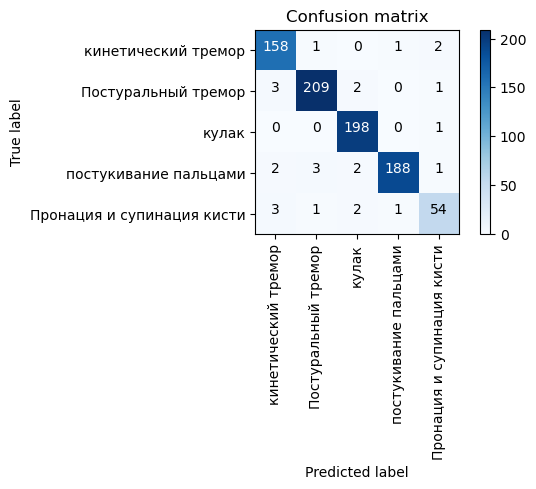

In [1332]:
catboost_votes_clf = build_and_check_votes_clf(catboost_clfs, catboost_X, catboost_y)

Accuracy=0.985594237695078
                            precision    recall  f1-score   support

       кинетический тремор       0.99      0.96      0.98       168
       Постуральный тремор       1.00      0.99      0.99       216
                     кулак       1.00      0.99      0.99       201
     постукивание пальцами       0.99      0.99      0.99       195
Пронация и супинация кисти       0.87      1.00      0.93        53

                  accuracy                           0.99       833
                 macro avg       0.97      0.99      0.98       833
              weighted avg       0.99      0.99      0.99       833

Confusion matrix, without normalization


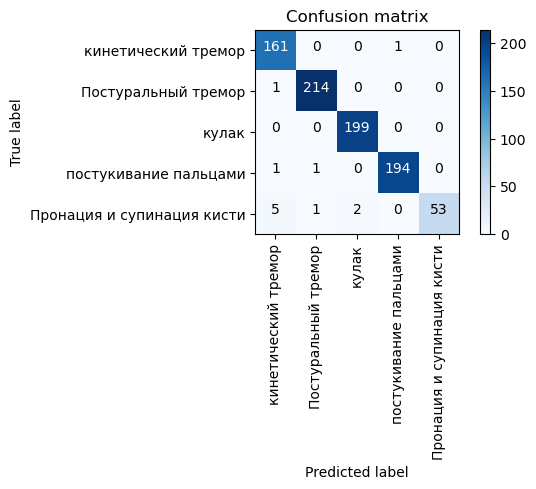

In [1333]:
xgb_votes_clf = build_and_check_votes_clf(xgb_clfs, xgb_X, xgb_y)

Accuracy=0.9303721488595438
                            precision    recall  f1-score   support

       кинетический тремор       0.90      0.90      0.90       162
       Постуральный тремор       0.92      0.98      0.95       200
                     кулак       0.99      0.96      0.98       206
     постукивание пальцами       0.94      0.95      0.94       194
Пронация и супинация кисти       0.84      0.72      0.77        71

                  accuracy                           0.93       833
                 macro avg       0.92      0.90      0.91       833
              weighted avg       0.93      0.93      0.93       833

Confusion matrix, without normalization


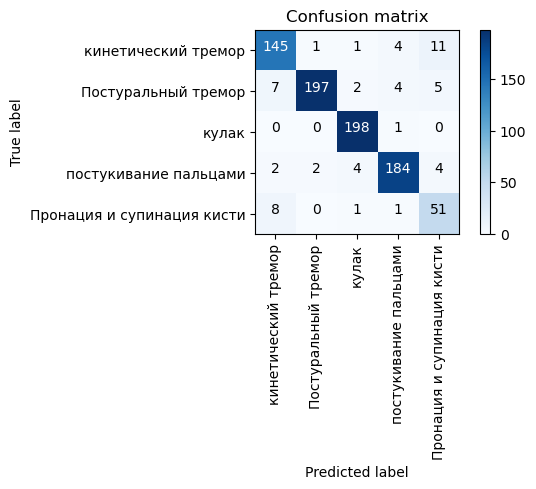

In [1334]:
tabnet_votes = build_and_check_votes_clf(tabnet_clfs, tabnet_X, tabnet_y)

Прогоним эту функцию и на алгоритмах, которые учились с t-SNE фичами, посмотрим, какие будут успехи

Accuracy=0.9555822328931572
                            precision    recall  f1-score   support

       кинетический тремор       0.97      0.92      0.94       171
       Постуральный тремор       0.96      0.97      0.97       214
                     кулак       0.99      0.95      0.97       208
     постукивание пальцами       0.95      0.99      0.97       189
Пронация и супинация кисти       0.77      0.92      0.84        51

                  accuracy                           0.96       833
                 macro avg       0.93      0.95      0.94       833
              weighted avg       0.96      0.96      0.96       833

Confusion matrix, without normalization


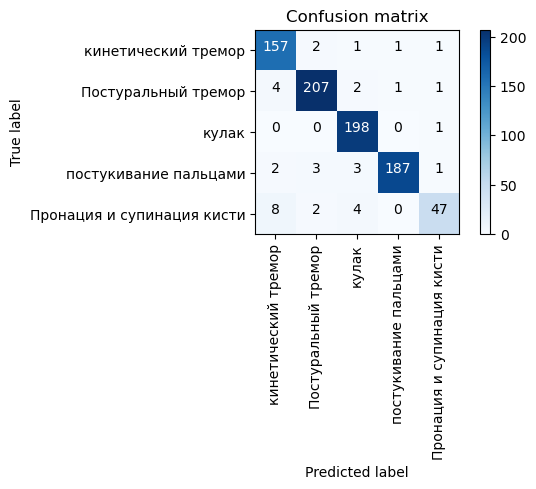

In [1335]:
catboost_votes_clf_with_tsne = build_and_check_votes_clf(catboost_clfs_with_tsne_feats, catboost_X_with_tsne, catboost_y_with_tsne)

Accuracy=0.9879951980792316
                            precision    recall  f1-score   support

       кинетический тремор       1.00      0.96      0.98       168
       Постуральный тремор       0.99      1.00      0.99       214
                     кулак       0.99      0.99      0.99       200
     постукивание пальцами       0.99      0.99      0.99       196
Пронация и супинация кисти       0.90      1.00      0.95        55

                  accuracy                           0.99       833
                 macro avg       0.98      0.99      0.98       833
              weighted avg       0.99      0.99      0.99       833

Confusion matrix, without normalization


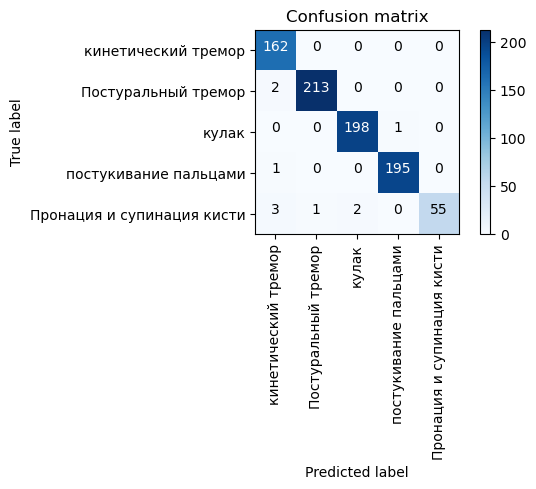

In [1336]:
xgb_votes_clf_with_tsne = build_and_check_votes_clf(xgb_clfs_with_tsne_feats, xgb_X_with_tsne, xgb_y_with_tsne)

Accuracy=0.9303721488595438
                            precision    recall  f1-score   support

       кинетический тремор       0.90      0.90      0.90       162
       Постуральный тремор       0.92      0.98      0.95       200
                     кулак       0.99      0.96      0.98       206
     постукивание пальцами       0.94      0.95      0.94       194
Пронация и супинация кисти       0.84      0.72      0.77        71

                  accuracy                           0.93       833
                 macro avg       0.92      0.90      0.91       833
              weighted avg       0.93      0.93      0.93       833

Confusion matrix, without normalization


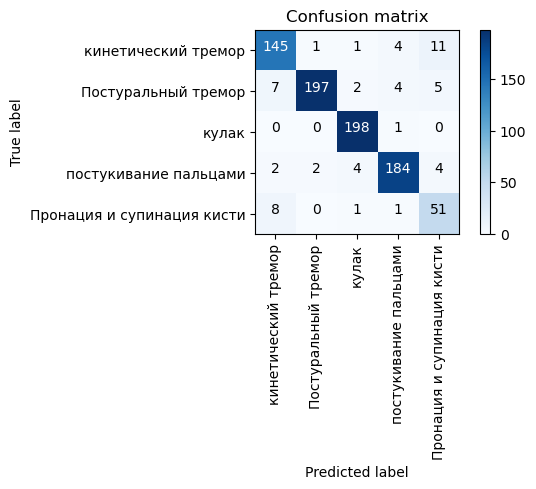

In [1337]:
tabnet_votes_clf_with_tsne = build_and_check_votes_clf(tabnet_clfs_with_tsne_feats, tabnet_X_with_tsne_feats, tabnet_y_with_tsne_feats)

Видно, что качество ансамблей достаточно неплохое на тренировке. Но проблема в том, что модели **похожие**. Давайте соберем нечто более интересное и стабильное из разных моделей.

## Интересное ансамблирование

Скопонуем решение xgb, catboost и tabnet (возьмем самые лучшие модели по валидации), потому что разные модели в ансамбле - чаще всего работают более устойчиво

Номера моделей выбрали так, чтобы их ансамбль давал лучшее значение на всех тренировочных данных

Accuracy=0.9771908763505402
                            precision    recall  f1-score   support

       кинетический тремор       0.97      0.95      0.96       165
       Постуральный тремор       0.97      0.99      0.98       211
                     кулак       1.00      0.99      0.99       202
     постукивание пальцами       0.98      0.99      0.99       193
Пронация и супинация кисти       0.93      0.92      0.93        62

                  accuracy                           0.98       833
                 macro avg       0.97      0.97      0.97       833
              weighted avg       0.98      0.98      0.98       833

Confusion matrix, without normalization


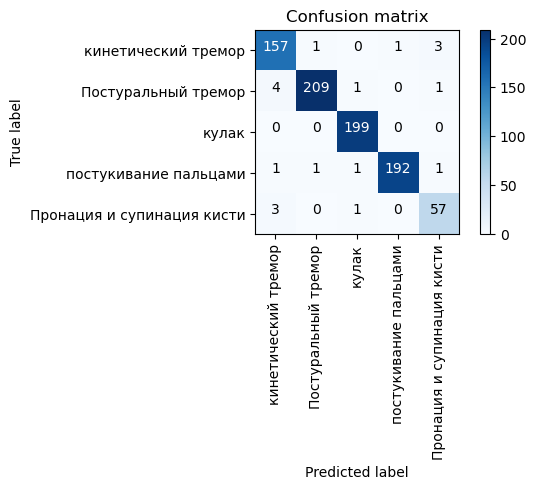

In [1338]:
xgb_and_catboost_and_tabnet_vots_clf = build_and_check_votes_clf([xgb_clfs[0], catboost_clfs[2], tabnet_clfs[0]], xgb_X, xgb_y)

In [1339]:
res_vot_cls = xgb_and_catboost_and_tabnet_vots_clf

## Check result algorithm on test dataset

In [1340]:
filtered_features

['distance_between_INDEX_FINGER_and_MIDDLE_FINGER_ends_max',
 'PINKY_angle_3_min',
 'distance_between_INDEX_FINGER_and_MIDDLE_FINGER_ends_mean',
 'distance_between_INDEX_FINGER_and_PINKY_ends_std',
 'MIDDLE_FINGER_angle_1_std',
 'INDEX_FINGER_angle_1_std',
 'folder_path',
 'diagnos',
 'PINKY_angle_3_mean',
 'INDEX_FINGER_angle_1_min',
 'MIDDLE_FINGER_angle_3_std',
 'PINKY_angle_3_max',
 'MIDDLE_FINGER_angle_2_std',
 'INDEX_FINGER_angle_3_std',
 'distance_between_INDEX_FINGER_and_MIDDLE_FINGER_ends_std',
 'distance_between_THUMB_and_PINKY_ends_max',
 'INDEX_FINGER_angle_2_max',
 'INDEX_FINGER_angle_1_mean',
 'INDEX_FINGER_angle_2_std',
 'MIDDLE_FINGER_angle_2_mean',
 'INDEX_FINGER_angle_2_min',
 'MIDDLE_FINGER_angle_3_min',
 'MIDDLE_FINGER_angle_1_mean',
 'distance_between_THUMB_and_MIDDLE_FINGER_ends_max',
 'distance_between_THUMB_and_MIDDLE_FINGER_ends_std',
 'INDEX_FINGER_angle_2_mean',
 'distance_between_THUMB_and_PINKY_ends_mean',
 'distance_between_THUMB_and_INDEX_FINGER_ends_min'

In [1341]:
def calc_score(new_df, is_public=True, add_columns=[]):
    X = new_df[filtered_features + add_columns].drop(TARGET_LABEL, axis=1, errors="ignore")
    y = new_df[TARGET_LABEL]
    print("Public:" if is_public else "Private:", accuracy_score(res_vot_cls.predict(X), y))

In [1342]:
new_df = add_tsne_features(
    transform_df_to_xgboost(
        test_feat_df[test_feat_df['private'] == 0].drop(columns='private').reset_index()
),train_cur_df=train_feat_df)
calc_score(new_df, is_public=True)

Public: 0.9752720079129574


In [1343]:
new_df = add_tsne_features(
    transform_df_to_xgboost(
        test_feat_df
), train_cur_df=train_feat_df)
calc_score(new_df, is_public=False)

Private: 0.9705882352941176


Without corr filtration:

public: 0.960

private: 0.953

With corr filtration:

public: 0.975

private: 0.9705